## Import

In [2]:
pip install cvxpy

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   -------- ------------------------------- 0.2/1.1 MB 5.0 MB/s eta 0:00:01
   ----------------------- ---------------- 0.7/1.1 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/742.5 kB ? eta -:--:--
   ---------------------- ---------------- 430.1/742.5 kB 13.5 MB/s eta 0:00:01
   ---------------------------------------- 742.5/742.5 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.7 kB ? eta -:--:--
   ---------------------------------------- 301.7/301.7 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.4 MB 20.5 MB/s eta 0:00:01
   - -------------------------------------- 0.4/7.4 MB 5.5 MB/s eta 0:00:02
   -- -----------------


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## Define the System (Discrete-Time)

In [31]:
# System definition
A = np.array([[1.0, 1.0],
              [0.0, 1.0]])
B = np.array([[0.0],
              [1.0]])
C = np.array([[1.0, 0.0]])

n = A.shape[0]
m = B.shape[1]

## MPC Parameters

In [32]:
N = 10
Q = np.eye(n)
R = 0.5 * np.eye(m)
sim_time = 30
x0 = np.array([[0.0], [0.0]])
x_ref = np.array([[10.0], [0.0]])

# Constraints
u_min, u_max = -1.0, 1.0
x_min, x_max = -5.0, 15.0

# Disturbance setup
np.random.seed(42)
disturbance_std = 0 #disturbances are set to 0 --> Put 0.2 to see the effects of disturbances

# Storage
x_hist = [x0]
u_hist = []
d_hist = []

## MPC Loop

In [33]:

x = x0.copy()

for t in range(sim_time):
    # Optimization variables
    x_var = cp.Variable((n, N + 1))
    u_var = cp.Variable((m, N))

    # Cost function and constraints
    cost = 0
    constraints = [x_var[:, 0] == x.flatten()]
    for k in range(N):
        cost += cp.quad_form(x_var[:, k] - x_ref.flatten(), Q)
        cost += cp.quad_form(u_var[:, k], R)

        # Dynamics constraint
        constraints += [x_var[:, k+1] == A @ x_var[:, k] + B @ u_var[:, k]]

        # Input and state constraints
        constraints += [cp.constraints.NonPos(u_var[:, k] - u_max)]
        constraints += [cp.constraints.NonPos(u_min - u_var[:, k])]
        constraints += [cp.constraints.NonPos(x_var[0, k] - x_max)]
        constraints += [cp.constraints.NonPos(x_min - x_var[0, k])]

    # Solve
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    # Apply control input
    u = u_var[:, 0].value.reshape(-1, 1)

    # Simulate with disturbance
    d = np.random.normal(0, disturbance_std, size=(n, 1))  # disturbance
    x = A @ x + B @ u + d

    # Store results
    x_hist.append(x)
    u_hist.append(u)
    d_hist.append(d)

# Convert to arrays
x_hist = np.hstack(x_hist)
u_hist = np.hstack(u_hist)
d_hist = np.hstack(d_hist)

## Results

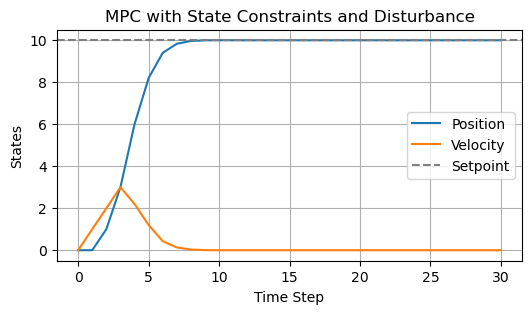

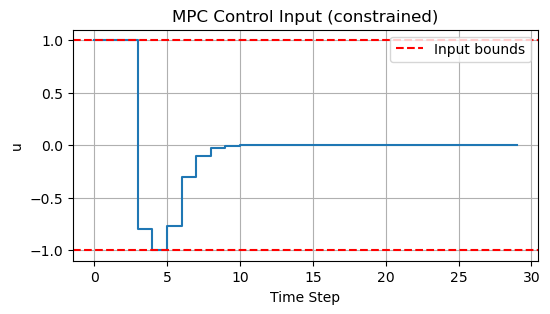

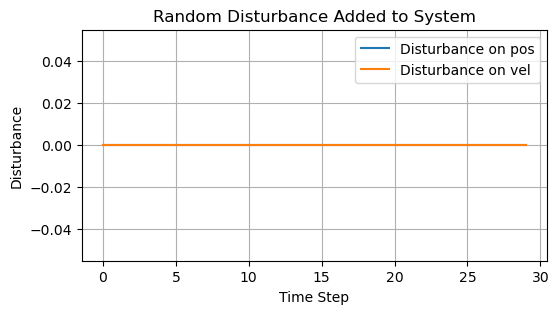

In [34]:
plt.figure(figsize=(6,3))
plt.plot(x_hist[0, :], label='Position')
plt.plot(x_hist[1, :], label='Velocity')
plt.axhline(x_ref[0, 0], linestyle='--', color='gray', label='Setpoint')
plt.title('MPC with State Constraints and Disturbance')
plt.xlabel('Time Step')
plt.ylabel('States')
plt.legend()
plt.grid(True)

plt.figure(figsize=(6,3))
plt.step(range(sim_time), u_hist[0, :], where='post')
plt.axhline(u_max, linestyle='--', color='red', label='Input bounds')
plt.axhline(u_min, linestyle='--', color='red')
plt.title('MPC Control Input (constrained)')
plt.xlabel('Time Step')
plt.ylabel('u')
plt.legend()
plt.grid(True)

plt.figure(figsize=(6,3))
plt.plot(d_hist[0, :], label='Disturbance on pos')
plt.plot(d_hist[1, :], label='Disturbance on vel')
plt.title('Random Disturbance Added to System')
plt.xlabel('Time Step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

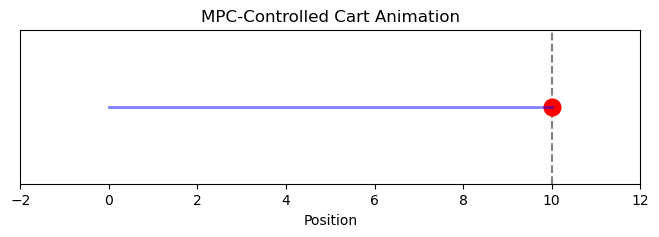

In [35]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 2))
ax.set_xlim(-2, 12)
ax.set_ylim(-1, 1)
ax.set_xlabel("Position")
ax.set_yticks([])
ax.set_title("MPC-Controlled Cart Animation")
target_line = ax.axvline(x=x_ref[0, 0], color='gray', linestyle='--', label='Target')
cart, = ax.plot([], [], 'ro', markersize=12)  # red cart dot

trail, = ax.plot([], [], 'b-', lw=2, alpha=0.5)
pos_data = []

def init():
    cart.set_data([], [])
    trail.set_data([], [])
    return cart, trail

def animate(i):
    x_pos = x_hist[0, i]
    pos_data.append(x_pos)
    cart.set_data([x_pos], [0])   # FIXED: wrap in list
    trail.set_data(pos_data, [0]*len(pos_data))
    return cart, trail

ani = animation.FuncAnimation(fig, animate, frames=len(x_hist[0]), init_func=init,
                              interval=200, blit=True)

HTML(ani.to_jshtml())